<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2024/blob/main/IMT_Arvores_de_Decisao_e_Mutual_Info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **Árvores de Decisão e Seleção de Atributos**
---

Nesta trilha você vai aprender:

*   Sobre Classificador de Árvores de Decisão
*   O que é Entropia, Ganho de Informação ou Informação Mútua, e como empregar essa e outras medidas para a seleção de atributos


Vamos partir aqui de um exemplo bastante simples de aplicação de árvores de decisão para, em seguida, explorarmos diversos conceitos que têm aplicação geral em modelos de aprendizado supervisionado, como entropia, informação mútua e ganho de informação. Você verá como esses conceitos são empregados para a seleção de atributos de aprendizado (*feature selection*).

No final você vai aprender o que são os *ensemble models* através de um dos mais importantes modelo *ensemble*, as Random Forests, e vamos adaptar o código da trilha anterior para de seleção de melhores hiperparâmetros para a seleção mais ampla de melhores modelos para classificação.  




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import seaborn as sns

# Árvores de Decisão e o Método Partitivo

O classificador de k-vizinhos mais próximos é bastante poderoso. Ele pode lidar de várias classes de problemas e fazer classificações com limites de decisão não lineares (diferentemente da regressão logística). O Knn entretanto precisa armazenar todos os dados de treinamento e, quanto mais dados de treinamento, maior o custo do processamento e mais lento ele se torna pois é preciso calcular a distância para todas as entradas de treinamento, mesmo existindo  estruturas de dados eficientes para pesquisa de vizinhos mais próximos. O uso de uma métrica de distância e a necessidade de atributos numéricos (ou transformados em numéricos) pode, em alguns casos, ser também uma limitação.

Você deve lembrar que os algoritmos de aprendizado de máquina buscam por  padrões nos dados, uma estrutura inerente que é inerente a eles. O Knn, por exemplo, parte da ideia de que semelhança entre itens vizinhos e que pontos de dados de várias classes não são espalhados aleatoriamente. Pelo contrário, as classes aparecem em grupos mais ou menos homogêneos. Assim se você sabe que um ponto de teste cai em um grupo com vários pontos de uma mesma classe, você sabe a classe de seus vizinhos mesmo sem calcular as distâncias para cada deles. É, neste caso, suficiente saber que o ponto de teste está em uma área onde todos os vizinhos são de uma classe. As árvores de decisão exploram exatamente isso.

As árvores de decisão estão explorando exatamente isso. Aqui, não são armazenados os dados de treinamento mas uma estrutura de árvore *'modela'* os dados e divide recursivamente o espaço em regiões com classes semelhantes. Essa estrutura faz particionamentos sucessivos dos dados em que as partições são cada vez mais *puras*, isto é, são cada vez mais homogêneas no sentido das classes que contêm.






![imagem](https://github.com/Rogerio-mack/BIG_DATA_Analytics_Mineracao_e_Analise_de_Dados/blob/main/figuras/DecisionTreePartitions.png?raw=true)


<small>
<b>
Figura 1. Particionamentos Sucessivos das Árvores de Decisão.

O nó raiz da árvore representa todo o conjunto de dados. Este conjunto é então dividido aproximadamente ao meio ao longo de uma dimensão (um atributo) por um limite simples. Todos os pontos que possuem um valor $\gt t$ caem no nó filho direito e todos os demais no nó filho esquerdo. O limiar $t$ a dimensão é escolhida de forma que os nós filhos resultantes sejam mais puros em termos de associação de classe. O ideal é que todos os pontos positivos (por exemplo, pontos laranja na figura acima) caiam em um nó filho e todos os pontos negativos (roxos) no outro. Se for esse o caso, a árvore está pronta. Caso contrário, os nós folha são novamente divididos até que eventualmente todas as folhas, ou nós terminais, sejam puras com todos seus pontos com o mesmo rótulo ou não podem ser mais divididos (dois pontos idênticos com rótulos diferentes, o que em casos reais podemos de fato ter).

Uma vez que a árvore é construída os dados de treinamento não precisam ser mais armazenados (como no Knn) pois a árvore *captura* todo o padrão dos dados, e você pode pensar em como uma única fórmula $ y = a_0 + a_1 x$ modela um conjunto de dados em uma regressão linear. A árvore passa a ser nossa '*fórmula*' de predição, as entradas de teste simplesmente precisam descer da árvore até uma folha que contendo a predição da classe, e são muito eficientes. Além disso as árvores de decisão não requerem métricas porque as divisões são baseadas em limites dos valores dos atributos (ou ainda suas proporções ou probabilidades) e não em distâncias.

# Construindo uma Árvore de Decisão: Algoritmo de Hunt

Vamos começar com um exemplo e entender como construir uma árvore de decisão a partir dos dados.



In [ ]:
# Exemplo livremente adaptado de:
# Weinberger, Kilian. **Machine Learning for Intelligent Systems**, Lecture 28: Decision / Regression Trees
#

df = pd.read_csv('http://meusite.mackenzie.br/rogerio/TIC/comics.csv',sep=';')
display(df)

cases = pd.read_csv('http://meusite.mackenzie.br/rogerio/TIC/comics_cases.csv',sep=';')
display(cases)

,Name,sex,smokes,tie,mask,cape,ears,class
0,Batman,male,no,no,yes,yes,yes,good
1,Robin,male,no,no,yes,yes,yes,good
2,Catwoman,female,no,no,yes,no,yes,bad
3,Joker,male,no,no,no,no,no,bad
4,Alfred,male,no,yes,no,no,no,good
5,Penguin,male,yes,yes,no,no,no,bad


,Name,sex,smokes,tie,mask,cape,ears,class
0,Batgirl,female,yes,yes,no,yes,no,?
1,Riddler,male,yes,no,no,no,no,?


O algoritmo de Hunt cria uma árvore de decisão de maneira recursiva, particionando os registros de treinamento em subconjuntos sucessivamente mais puros. Seja $D_t$ o conjunto de registros de treinamento que atingem um nó $t$. O procedimento recursivo é, então, o seguinte:

1. Se $D_t$ contém registros que pertencem à mesma classe $y_t$, então $t$ é um nó folha rotulado como $y_t$

2. Se $D_t$ for um conjunto vazio, então $t$ é um nó folha rotulado pela classe padrão, $y_d$

3. Se $D_t$ contiver registros que pertencem a mais de uma classe, use um teste de atributo para dividir os dados em subconjuntos menores.

Ele aplica recursivamente o procedimento a cada subconjunto até que todos os registros no subconjunto pertençam à mesma classe. O algoritmo de Hunt assume que cada combinação de conjuntos de atributos possui um rótulo de classe exclusivo durante o procedimento. Se todos os registros associados a $D_t$ tiverem valores de atributo idênticos, exceto para o rótulo da classe, não será possível dividir esses registros no futuro. Nesse caso, o nó é classificado como um nó folha com o mesmo rótulo de classe que a classe principal de registros de treinamento associados a este nó.

O procedimento talvez seja mais claro de *ver* do que *ler*...

![imagem](https://github.com/Rogerio-mack/BIG_DATA_Analytics_Mineracao_e_Analise_de_Dados/blob/main/figuras/DecisionTree3.png?raw=true)


<small>
<b>
Figura 2. Construção de uma Árvore de Decisão pelo algoritmo de Hunt.

No exemplo acima escolhemos arbitrariamente iniciar o particionamento dos dados pelo atributo `cape`, como para todos os casos `cape = yes` temos somente alunos `good` esse ramo se torna um nó folha ou terminal, e dados que seguem nesse ramo já estão classificados e não serão mais considerados. Para os casos `cape = no` há alunos `good` e `bad` e, portanto, não podemos decidir e é necessário adicionarmos um novo nó com outro atributo. Note que nesse ramo só teremos agora dados com `cape = no`. Escolhemos novamente de modo arbitrário o atributo `tie` de realizamos novamente o *split* dos dados. Agora, os casos com  `tie = no` (e `cape = no`!, pois é o ramo que estamos) são todos da mesma classe e são, portanto, um nó terminal. Para `tie = yes` (e ainda `cape = no`!) precisamos adicionar ainda um novo particionamento com o atributo `smokes`.

Note que o que a estrutura de árvore faz é simplesmente definir sucessivos particionamentos dos dados buscando partições cada vez mais *puras* (somente classes *good* ou *bad*).

![imagem](https://github.com/Rogerio-mack/BIG_DATA_Analytics_Mineracao_e_Analise_de_Dados/blob/main/figuras/DecisionTree1.png?raw=true)



<small>
<b>
Figura 3. Árvore de Decisão e o particionamento dos dados.

No exemplo acima fizemos escolhas arbitrárias dos atributos para a construção da árvore. Se escolhêssemos outros atributos ou em uma ordem diferentes chegaríamos a outras árvores de decisão que poderíamos igualmente empregar para a classificação dos dados.

![imagem](https://github.com/Rogerio-mack/BIG_DATA_Analytics_Mineracao_e_Analise_de_Dados/blob/main/figuras/DecisionTree4.png?raw=true)


<small>
<b>
Figura 4. Diferentes possíveis Árvores de Decisão para um mesmo conjunto de dados.

Mas, como você pode ver, existem árvores melhores e piores. O atributo `tie` na raiz, por exemplo, não permite particionarmos dados de forma a eliminar quaisquer dos dados e, portanto, *ele não fornece qualquer informação útil para determinar a classe dos dados*. A ideia é de árvores mais eficientes possam *otimizar* a cada nível a *pureza* das partições. Você entenderá como podemos fazer isso mais adiante em que empregaremos o *ganho de informação* como uma medida para definir melhores partições dos dados a cada nível.

# Outros Algoritmos

Os algoritmos de Árvore de Decisão constroem as Árvores do mesmo modo recursivo que construímos aqui. Todos eles buscam particionamentos que maximizem a decisão, tornando a Árvores e os caminhos que temos que percorrer menores. Eles buscam a cada nível da Árvore (partição) uma maior informação para “pureza” das partições dos dados em termos de sua classe.


> Diferentes algoritmos de Árvores de Decisão e seus critérios para seleção dos nós:
>> * ID3 algorithm (Claude Shannon Entropy): Ganho do de Informação
>> * C4.5 algorithm: Gain ratio
>> * CART algorithm: Gini index

Seja qual for o método empregado a ideia é a mesma. Existem particionamentos que alteram pouco a distribuição dos dados entre as classes e trazem, portanto, pouca informação adicional para a classificação, e outros que proporcionam informação maior para a decisão.

O pseudo código abaixo é o algoritmo clássico apresentado por Mitchell, Tom Michael (1997) em seu clássico livro de Aprendizado de Máquina.


In [ ]:
%%script false
# Adaptado de, Mitchell, Tom Michael (1997). Machine Learning.

def ID3 (Examples, Target_Attribute, Attributes):

    Create a root node for the tree
    if all examples are positive, return the single-node tree Root, with label = +.
    if all examples are negative, return the single-node tree Root, with label = -.

    if number of predicting attributes is empty:
      return the single node tree Root, with label = most common value of the target attribute in the examples.
    else:
        A ← The Attribute that best classifies examples.
        Decision Tree attribute for Root = A.
        for each possible value, vi, of A,
            Add a new tree branch below Root, corresponding to the test A = vi.
            Let Examples(vi) be the subset of examples that have the value vi for A
            if Examples(vi) is empty
              below this new branch add a leaf node with label = most common target value in the examples
            else below this new branch add the subtree ID3 (Examples(vi), Target_Attribute, Attributes – {A})
    End

# Decision Tree, scikit-learn

Antes de prosseguirmos vamos explorar o classificador de árvore de decisão do `scikit-learn` no nosso exemplo de brinquedo.

Os modelos de árvore de decisão podem lidar com variáveis categóricas sem codificá-las de uma só vez. Veja que nosso exemplo os valores atributos tinham valores 'yes' ou 'no' e, em nenhum momento precisamos supor ou transformá-los em numéricos. Entretanto as implementações mais populares de árvores de decisão, incluindo o `scikit-learn` não honram esse fato e requerem o encode dos dados categóricos, apesar da degradação do desempenho do modelo de árvore que isso traz. Desse modo precisamos proceder o encode dos dados para empregarmos o classificador de árvore de decisão do `scikit-learn`. Mas lembre-se, que isso é uma limitação apenas da implementação.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df_labels = df.drop(columns=['Name','class']).apply(LabelEncoder().fit_transform)
cases_labels = cases.drop(columns=['Name','class']).apply(LabelEncoder().fit_transform)

display( pd.concat([df.Name, df_labels, df['class']], axis=1) )
display( pd.concat([cases.Name, cases_labels, cases['class']], axis=1) )

,Name,sex,smokes,tie,mask,cape,ears,class
0,Batman,1,0,0,1,1,1,good
1,Robin,1,0,0,1,1,1,good
2,Catwoman,0,0,0,1,0,1,bad
3,Joker,1,0,0,0,0,0,bad
4,Alfred,1,0,1,0,0,0,good
5,Penguin,1,1,1,0,0,0,bad


,Name,sex,smokes,tie,mask,cape,ears,class
0,Batgirl,0,0,1,0,1,0,?
1,Riddler,1,0,0,0,0,0,?


Neste exemplo simples, havendo para todos atributos somente dois valores, podemos fazer o `LabelEncoder` dos dados, tendo o mesmo resultado que teríamos ao empregar o `OneHotEncoder(drop='if-binary')`.

Como estamos interessados apenas em *explorar* o modelo, por hora podemos deixar de lado a separação de dados de treinamento e teste. O estimador `DecisionTreeClassifier()` segue então a mesma forma de uso que empregamos até agora.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X = df_labels
y = df['class']

clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(X,y)
y_pred = clf.predict(X)
print( clf.score(X,y) )


1.0


E podemos então fazer predições a partir do modelo construído.

<img src="https://universoheroico.com.br/wp-content/uploads/2021/05/Imagem-da-batgirl.jpg" width=300, align="center">

<img src="https://images6.fanpop.com/image/photos/43600000/Edward-Nygma-The-Riddler-in-Batman-no-23-2-dc-comics-43657990-900-507.jpg" width=300, align="center">






<small>
<b>
Figura 5. Personagens para predição. <br></b>(Fonte: imagens de divulgação, https://universoheroico.com.br e https://images6.fanpop.com)

In [ ]:
y_pred = clf.predict(cases_labels)
cases['class'] = y_pred
display( cases )

,Name,sex,smokes,tie,mask,cape,ears,class
0,Batgirl,female,yes,yes,no,yes,no,good
1,Riddler,male,yes,no,no,no,no,bad


Uma das grandes vantagens dos modelos de Árvore de Decisão é sua *interpretabilidade*. Um tema cada vez mais exigido dos modelos de aprendizado de máquina à medida que eles são mais e mais empregados em decisões que influenciam o dia a dia e o destino das pessoas (por exemplo, aplicações na no processo seletivo das empresas ou a previsibilidade de crimes).

Essa interpretabilidade é em grande parte pela possibilidade de podermos *enxergar* como é tomada a decisão do classificador observando a estrutura da árvore ou, ao menos, a cadeia de particionamentos criada. O `scikit-learn` fornece algumas formas de visualização da árvore criada sendo a mais simples, o `plot_tree()`.  

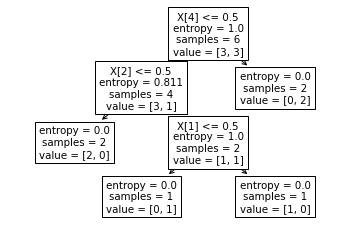

In [ ]:
from sklearn import tree

tree.plot_tree(clf)
plt.show()

Mas resultados muito melhores podem ser obtidos com o pacote `graphviz`.

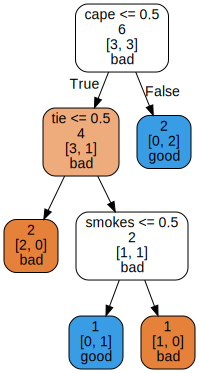

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=list(df_labels.columns.values),
                     class_names=list(sorted(df['class'].unique())),
                     filled=True, rounded=True,
                     special_characters=False,
                     proportion=False, impurity=False, node_ids=False,label=None)
graph = graphviz.Source(dot_data)
graph.render('graph_cartoons') # para gravação em .pdf
graph

Revisando a árvore acima podemos reproduzir os particionamentos criados e notar que o 'aprendizado' do modelo pode ser facilmente interpretado por uma série de condições (*ifs*) encadeados.

In [ ]:
df_tree = pd.concat([df_labels, df['class']], axis=1)

print('Root level')
print(60*'-')
display(df_tree)
print('Continue Next Level...')
display(df_tree[df_tree.cape<=0.5])
print('Terminal')
display(df_tree[df_tree.cape>0.5])

print('\n\n\nSecond level')
print(60*'-')
display(df_tree[df_tree.cape<=0.5])
print('Continue Next Level...')
display(df_tree[(df_tree.cape<=0.5) & (df_tree.tie>0.5)])
print('Terminal')
display(df_tree[(df_tree.cape<=0.5) & (df_tree.tie<=0.5)])

print('\n\n\nThird level')
print(60*'-')
display(df_tree[(df_tree.cape<=0.5) & (df_tree.tie>0.5)])
print('Terminal')
display(df_tree[(df_tree.cape<=0.5) & (df_tree.tie>0.5) & (df_tree.smokes<=0.5) ])
print('Terminal')
display(df_tree[(df_tree.cape<=0.5) & (df_tree.tie>0.5) & (df_tree.smokes>0.5)])

Root level
------------------------------------------------------------


,sex,smokes,tie,mask,cape,ears,class
0,1,0,0,1,1,1,good
1,1,0,0,1,1,1,good
2,0,0,0,1,0,1,bad
3,1,0,0,0,0,0,bad
4,1,0,1,0,0,0,good
5,1,1,1,0,0,0,bad


Continue Next Level...


,sex,smokes,tie,mask,cape,ears,class
2,0,0,0,1,0,1,bad
3,1,0,0,0,0,0,bad
4,1,0,1,0,0,0,good
5,1,1,1,0,0,0,bad


Terminal


,sex,smokes,tie,mask,cape,ears,class
0,1,0,0,1,1,1,good
1,1,0,0,1,1,1,good





Second level
------------------------------------------------------------


,sex,smokes,tie,mask,cape,ears,class
2,0,0,0,1,0,1,bad
3,1,0,0,0,0,0,bad
4,1,0,1,0,0,0,good
5,1,1,1,0,0,0,bad


Continue Next Level...


,sex,smokes,tie,mask,cape,ears,class
4,1,0,1,0,0,0,good
5,1,1,1,0,0,0,bad


Terminal


,sex,smokes,tie,mask,cape,ears,class
2,0,0,0,1,0,1,bad
3,1,0,0,0,0,0,bad





Third level
------------------------------------------------------------


,sex,smokes,tie,mask,cape,ears,class
4,1,0,1,0,0,0,good
5,1,1,1,0,0,0,bad


Terminal


,sex,smokes,tie,mask,cape,ears,class
4,1,0,1,0,0,0,good


Terminal


,sex,smokes,tie,mask,cape,ears,class
5,1,1,1,0,0,0,bad


# Entropia e Ganho de Informação

Voltando ao nosso exemplo a árvore construída foi a mesma que construímos antes (lembre-se, poderíamos ter outras árvores construídas) mas a escolha não foi aqui arbitrária. A escolha dos atributos para a definição dos nós da árvore seguiu o critério empregar os atributos com maior *ganho de informação* para maximizar a *pureza* dos particionamentos.

Você pode entender o *ganho de informação* como uma medida de quanto a informação de um atributo contribui para diminuir a incerteza sobre outro, assim, o ganho de informação de `cape` para determinar `class`, $G(cape, class)$, deve ser maior que o ganho de informação dos demais atributos.

Mas para entendermos o ganho de informação precisamos antes entender o conceito de entropia.






## Entropia

Na teoria da informação, a entropia é uma medida de quantidade de informação introduzido por Claude Shannon em seu artigo de 1948 *A Mathematical Theory of Communication*. A entropia de um atributo é o nível médio de informação, surpresa,  ou  ainda incerteza, inerente aos resultados possíveis desse atributo. Ela é definida como:

$$ E(s) = - \sum_i p_i log p_i $$

onde $p_i$ é a probabilidade dos $i$ valores de $s$.

Um *bit*, por exemplo, é a unidade de informação exatamente por que carrega *1* de entropia:      

$$ E(bit) = - p(0) log( p(0) ) - p(1) log( p(1) )  = - \frac{1}{2} log \frac{1}{2} - \frac{1}{2} log \frac{1}{2} = 1  $$

onde $p(0)$ e $p(1)$ são respectivamente as probabilidades do bit $0$ e $1$.

Assim, podemos ver também que a entropia de uma constante é zero, pois não há qualquer incerteza sobre seu valor:     

$$ E(cte) = - 1 log 1 = 0 $$

e é exatamente isso que queremos buscar em um particionamento ao construírmos uma árvore de decisão.

Podemos empregar o pacote `scipy` para determinar a entropia de dados com base nas probabilidades dos diferentes valores e, abaixo, você pode ver a entropia do *bit* e de uma constante.






In [ ]:
from scipy.stats import entropy
E = entropy( [1/2, 1/2] , base=2 )
E

1.0

In [ ]:
E = entropy( 1 , base=2 )
E

0.0

## Ganho de Informação

O ganho de informação de um atributo com relação a uma variável classe objetivo ($T$, Target) é, portanto, uma medida de quanto a informação desse atributo diminui a incerteza sobre a classe dos dados, ou seu valor no caso de uma regressão. O ganho de informação pode ser então expresso em termos da entropia como:     

$$ G_{T}(s) = E(T) - \sum_i p_i E(T | s_i) $$

Onde $E(T)$ é a entropia do atributo objetivo e a somatória é a média ponderada da entropia do atributo target para os diferentes conjuntos de dados com valor $s_i$.


![imagem](https://github.com/Rogerio-mack/BIG_DATA_Analytics_Mineracao_e_Analise_de_Dados/blob/main/figuras/EntropiaGanhoInformacao.png?raw=true)

<small>
<b>
Figura 6. Exemplo do Cálculo de Entropia e Ganho de Informação.

O exemplo acima mostra o cálculo do ganho de informação do atributo *Hello*, indicando emails iniciando ou não por *Hello*, para a determinação da classe desses emails, *Spam* ou *Not Spam*.

# Ganho de Informação, Índice Gini e Classification Error

Você deve ter notado que ao empregarmos o classificador `DecisionTreeClassifier()` empregamos um parâmetro `criterion`, `DecisionTreeClassifier(criterion='entropy')`. Isso por que existem outras métricas de cálculo do ganho de informação como o  Índice Gini e o Classification Error sendo o padrão do `scikit-learn` o emprego do Índice Gini, `DecisionTreeClassifier(criterion='gini)`. Essas medidas são definidas como:      

$$ Gini(s) = 1 - \sum_i p_i $$

e

$$ CE(s) = 1 - max p_i $$

<br>

E são empregadas dos mesmo modo que a entropia para o cálculo do ganho de informação:

$$ IG_{Gini}(s) = Gini(T) - \sum_i p_i Gini(T | s_i) $$

e

$$ IG_{CE}(s) = CE(T) - \sum_i p_i CE(T | s_i) $$


Tanto a entropia como o índice gini e o classification error são igualmente medidas de impuridade (0, para nenhuma incerteza dos dados) sendo apenas funções com diferentes medidas mas que preservam a mesma ordem de medida, isto é, um maior valor de entropia sempre leva a maiores valores do índice gini e do classification error, como você pode observar abaixo.

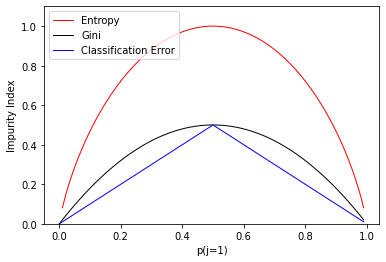

In [ ]:
# you can skip this code!

# Adaptado de: https://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php
import matplotlib.pyplot as plt
import numpy as np

def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
c_err = [classification_error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for j, lab, c, in zip(
      [ent, gini(x), c_err],
      ['Entropy', 'Gini', 'Classification Error'],
      ['red', 'black', 'blue']):
   line = ax.plot(x, j, label=lab, lw=1, color=c)

ax.legend(loc='upper left', ncol=1, fancybox=True, shadow=False)

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()

# Entropia e Ganho de Informação com Python

Você pode agora empregar as definições acima para verificar o ganho de informação de cada atributo do nosso exemplo de brinquedo.

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y+0.01, value, ha="center", fontsize=14)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [ ]:
# you can skip this code!

from scipy.stats import entropy

def informationgain(df,target,base=2):
  E = entropy( df[target].value_counts() / len(df) , base=base )

  E_x = {}

  for c in df.drop(columns=[target]):
    E_x[c] = []
    for v in df[c].unique():
      e = len(df[df[c]==v])/len(df) * entropy( df[df[c]==v]['class'].value_counts() / len(df[df[c]==v]), base=base )
      E_x[c].append(np.round(e,2))

  ig = {}

  for c, p in E_x.items():
    ig[c] = E - sum(p)

  return ig

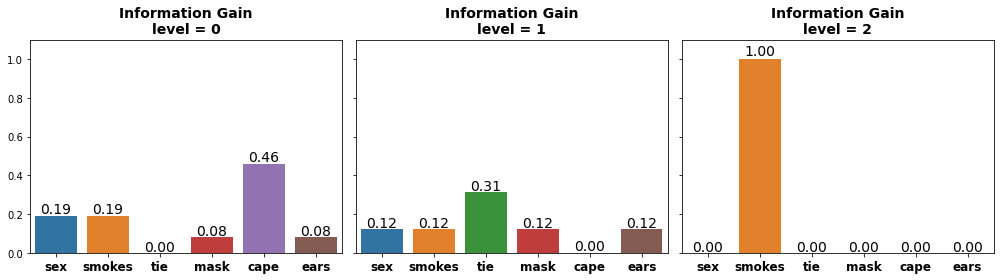

In [ ]:
# you can skip this code!

ig_root = informationgain(df=df.drop(columns=['Name']),target='class')
ig_level_1 = informationgain(df=df.drop(columns=['Name'])[df.cape == 'no'],target='class')
ig_level_2 = informationgain(df=df.drop(columns=['Name'])[ (df.cape == 'no') & (df.tie == 'yes') ],target='class')

f , ax = plt.subplots(1,3,figsize=(14,4),sharey=True)

for i, ig_  in enumerate([ ig_root, ig_level_1, ig_level_2 ]):
  sns.barplot(x=list(ig_.keys()), y=list(ig_.values()), ax=ax[i])
  ax[i].set_title('Information Gain\nlevel = ' + str(i), fontsize=14, weight='bold')
  ax[i].set_ylim([0,1.1])

  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12, weight='bold')
  show_values(ax[i])

plt.tight_layout()
plt.show()

Como você pode ver as escolhas dos atributos em cada nível segue exatamente o maior ganho de informação recalculado a cada nível da árvore.

# Informação Mútua e Seleção de Atributos

Toda essa discussão sobre o ganho de informação talvez não fosse tão importante se isso estivesse limitado ao uso em modelos de Árvore de Decisão. O ganho de informação, entretanto, é útil para a construção de muitos outros modelos pois nos dá um meio de avaliarmos atributos que são potencialmente mais preditores que outros, algo que ainda não havíamos explorado. Dentro da seleção de atributos para modelos preditivos, ou *feature selection*, o ganho de informação é normalmente denominado informação mútua (*mutual information*), correspondendo ao mesmo cálculo que você viu do ganho de informação empregando a Entropia, para entropia com base $e$ ($ln$ ou $log_{e}$).




In [ ]:
df_tree

,sex,smokes,tie,mask,cape,ears,class
0,1,0,0,1,1,1,good
1,1,0,0,1,1,1,good
2,0,0,0,1,0,1,bad
3,1,0,0,0,0,0,bad
4,1,0,1,0,0,0,good
5,1,1,1,0,0,0,bad


In [ ]:
from sklearn.feature_selection import mutual_info_classif

print(mutual_info_classif(df_tree.drop(columns=['class']), df_tree['class'], discrete_features=True))

[0.13230412 0.13230412 0.         0.05663301 0.31825708 0.05663301]


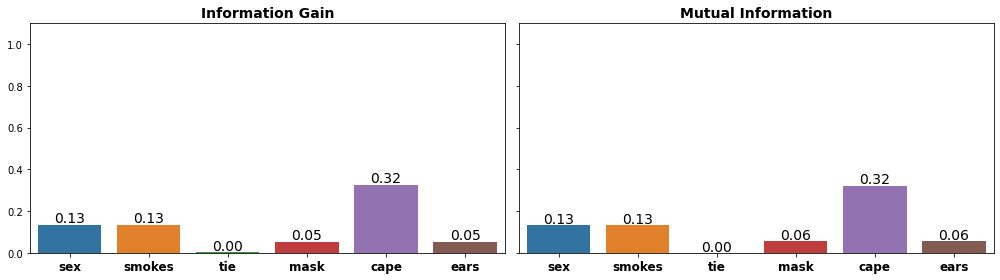

In [ ]:
f , ax = plt.subplots(1,2,figsize=(14,4),sharey=True)

ig_root = informationgain(df=df.drop(columns=['Name']),target='class',base=None)

i = 0
sns.barplot(x=list(ig_root.keys()), y=list(ig_root.values()), ax=ax[i])
ax[i].set_title('Information Gain', fontsize=14, weight='bold')
ax[i].set_ylim([0,1.1])

ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12, weight='bold')
show_values(ax[i])

mutualinfo = mutual_info_classif(df_tree.drop(columns=['class']), df_tree['class'], discrete_features=True)

i = 1
sns.barplot(x=df_tree.drop(columns=['class']).columns, y=mutualinfo , ax=ax[i])
ax[i].set_title('Mutual Information', fontsize=14, weight='bold')
ax[i].set_ylim([0,1.1])

ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12, weight='bold')
show_values(ax[i])

plt.tight_layout()
plt.show()

# Seleção de Atributos

A seleção de atributos para construção de um modelo tem muitos aspectos, incluindo muitos aspectos no domínio do problema (e não da solução!), e não seria possível abordarmos todos aqui. Mas vale a pena vermos algumas dessas técnicas e aprender a empregar o `scikit-learn` nessa tarefa. Depois de abordagens que envolvem basicamente o entendimento dos dados, como excluir atributo único para cada instância ou um atributo com muitos dados ausentes, mas antes de empregar a informação mútua para a seleção de atributos, vale a pena removermos atributos de pouca variância: eles



As classes do `sklearn.feature_selection` podem ser usadas para seleção de atributos  e redução de dimensionalidade em conjuntos de amostras, seja para melhorar o *score* dos estimadores ou para impulsionar seu desempenho em conjuntos de dados de dimensões muito altas.



## Removendo dados com pouca variância

O `VarianceThreshold` permite remover todos os atributos com variância abaixo de um limite e, por padrão, remove todos atributos de variância zero (mesmo valor em todas as amostras), são os dados que não carregam nenhuma informação ou, como você viu entropia $E(cte) = 0$. O


In [ ]:
df_tree.var()

sex       0.166667
smokes    0.166667
tie       0.266667
mask      0.300000
cape      0.266667
ears      0.300000
dtype: float64

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X = df_tree.drop(columns=['class'])
sel = VarianceThreshold(threshold=0.1)
sel.fit_transform(X)

array([[1, 0, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0]])

No nosso exemplo há poucos atributos e as variâncias próximas não permitem selecionar atributos para remoção. Mas o exemplo vale para mostrar como empregar o estimador.

## Selecionando atributos com o `SelectKBest`

A seleção univariada de recursos funciona selecionando os melhores atributos com base em testes estatísticos univariados, o que inclui a informação mútua. São 3 métodos, mas que tem o mesmo tipo de princípio:

* `SelectKBest` remove tudo, exceto os atributos de maior pontuação

* `SelectPercentile` remove todos os atributos, exceto a maior porcentagem de pontuação especificada

* `GenericUnivariateSelect`permite realizar a seleção univariada de recursos com uma estratégia configurável

Aplicando o  `SelectKBest` ao nosso exemplo teríamos:

In [ ]:
df_tree

,sex,smokes,tie,mask,cape,ears,class
0,1,0,0,1,1,1,good
1,1,0,0,1,1,1,good
2,0,0,0,1,0,1,bad
3,1,0,0,0,0,0,bad
4,1,0,1,0,0,0,good
5,1,1,1,0,0,0,bad


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

X = df_tree.drop(columns=['class'])
y = df_tree['class']

select_features = SelectKBest(mutual_info_classif, k=3).fit(X, y)
print( select_features.get_support() )
print( X.columns[select_features.get_support()] )

X_new = select_features.transform(X)

pd.DataFrame( X_new, columns= X.columns[select_features.get_support()] )

[ True False False False  True  True]
Index(['sex', 'cape', 'ears'], dtype='object')


,sex,cape,ears
0,1,1,1
1,1,1,1
2,0,0,1
3,1,0,0
4,1,0,0
5,1,0,0


Esses métodos podem ser empregados tanto para modelos de classificação como de regressão com diferentes métricas de pontuação:

* Para a regressão: `f_regression, mutual_info_regression`

* Para a classificação: `chi2, f_classif, mutual_info_classif`

E você deve ter cuidado para não empregar métricas de classificação em modelos de regressão e vice-versa.

## Limitações

Note que se fizermos a seleção de features como acima, teríamos eliminado o atributo `tie`, assim como o atributo `smokes` pelo critério de variância mínima, dois atributos que foram empregados no modelo de árvore. Isso por que esses critérios somente levam em consideração a variância e a informação mútua unicamente do atributo, sem levar em conta possíveis relações dos atributos para a predição. Assim, é importante você ter bastante cuidado ao remover dados de modelo a partir de critérios univariados.

## Eliminação recursiva de atributos

Uma última técnica que trataremos aqui é a eliminação recursiva de atributos. A maior parte dos estimadores fornece, após o treinamento, a importância de cada atributo (como `estimador.coef_` ou `estimador.feature_importances_`). A eliminação recursiva de recursos (RFE) consiste em selecionar atributos considerando recursivamente conjuntos cada vez menores na quantidade de atributos. Primeiro, o estimador é treinado no conjunto inicial, em seguida, os atributos menos importantes são removidos do conjunto atual repetindo-se o  procedimento recursivamente até um número desejado.

`RFECV` executa RFE em um loop de validação cruzada para encontrar o número ideal de recursos e o exemplo poderá ser útil para aplicar em conjuntos de dados mais complexos que o nosso conjunto de dados de brinquedo.



Optimal number of features : 1


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


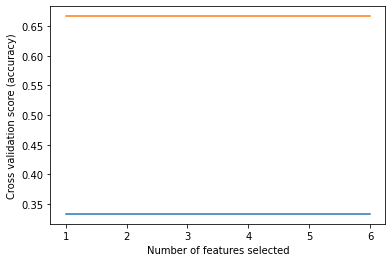

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV

X = df_labels
y = df['class']

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X,y)

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=2,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
pd.DataFrame({'atributtes':  df_labels.columns, 'feature_importances': clf.feature_importances_}).sort_values('feature_importances',ascending=False)

,atributtes,feature_importances
4,cape,0.459148
1,smokes,0.333333
2,tie,0.207519
0,sex,0.000000
3,mask,0.000000
5,ears,0.000000


# Um exemplo clássico

Antes de prosseguir talvez você queira revisar aqui alguns pontos de como empregar o classificador `DecisionTreeClassifier` no exemplo clássico de Mitchell, Tom Michael (1997). Machine Learning.

In [ ]:
df = pd.read_csv('http://meusite.mackenzie.br/rogerio/ML/PlayBallcsv.csv')
df.head()

,Day,Outlook,Temperature,Humidity,Wind,Play ball
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


Primeiramente você precisa fazer o encode dos dados, uma restrição da implementação do `scikit-learn`.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df_labels = df.drop(columns=['Day','Play ball']).apply(LabelEncoder().fit_transform)

pd.concat([ df_labels, df[['Play ball']] ], axis=1).head()

,Outlook,Temperature,Humidity,Wind,Play ball
0,2,1,0,1,No
1,2,1,0,0,No
2,0,1,0,1,Yes
3,1,2,0,1,Yes
4,1,0,1,1,Yes


O uso do estimador segue do mesmo modo que já empregamos para o estimador logístico, o Knn e é a forma de empregarmos qualquer modelo de aprendizado supervisinado.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X = df_labels
y = df['Play ball']

clf = DecisionTreeClassifier()

clf.fit(X,y)
y_pred = clf.predict(X)
print( clf.score(X,y) )


1.0


Você pode achar útil visualizar a árvore de decisão criada  com o `graphviz`.

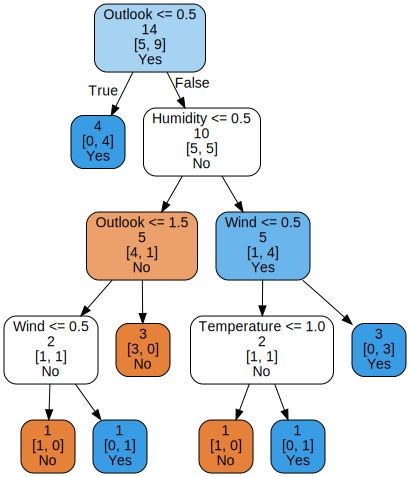

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=list(df_labels.columns.values),
                     class_names=list(sorted(df['Play ball'].unique())),
                     filled=True, rounded=True,
                     special_characters=False,
                     proportion=False, impurity=False, node_ids=False,label=None)
graph = graphviz.Source(dot_data)
graph.render('graph_cartoons') # para gravação em .pdf
graph

E a informação mútua e o peso dos atributos no classificador fornecem informações úteis para análises dos modelos em muitos casos.

In [ ]:
print(X.columns)
print(mutual_info_classif(X, y, discrete_features=True))
print(clf.feature_importances_)

Index(['Outlook', 'Temperature', 'Humidity', 'Wind'], dtype='object')
[0.17103394 0.02025554 0.10524435 0.03335912]
[0.31555556 0.15555556 0.28       0.24888889]


# CASO: Classifying Political Parties Based on Congressional Votes

Este conjunto de dados inclui votos para cada um dos congressistas da Câmara dos Representantes dos EUA nos 16 votos principais identificados pelo CQA. Nosso objetivo é construir selecionar um melhor modelo para prever a filiação partidária dos congressistas com base nos registros de votação.

Fonte: http://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records



In [ ]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',header=None,prefix='Vote_')
df.rename(columns={'Vote_0':'class'},inplace=True)
df.head()

,class,Vote_1,Vote_2,Vote_3,Vote_4,Vote_5,Vote_6,Vote_7,Vote_8,Vote_9,Vote_10,Vote_11,Vote_12,Vote_13,Vote_14,Vote_15,Vote_16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [ ]:
df.shape

(435, 17)

## Preparação dos Dados

Não existem dados ausentes, a as abstenções '?' são um grande número de casos. Vamos esperar que elas possam também ajudar a identificar o partido do congressista uma vez que isso parece ser mais uma informação importante do que exatamente ausência de informação.

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
(df == '?').sum()

class        0
Vote_1      12
Vote_2      48
Vote_3      11
Vote_4      11
Vote_5      15
Vote_6      11
Vote_7      14
Vote_8      15
Vote_9      22
Vote_10      7
Vote_11     21
Vote_12     31
Vote_13     25
Vote_14     17
Vote_15     28
Vote_16    104
dtype: int64

Agora precisamos fazer o encode dos dados. A rigor deveríamos fazer o hot encode, mas por simplificidade será suficiente aqui fazermos apenas o label encode do dados.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df_labels = df.drop(columns=['class']).apply(LabelEncoder().fit_transform)

pd.concat([ df_labels, df[['class']] ], axis=1).head()

,Vote_1,Vote_2,Vote_3,Vote_4,Vote_5,Vote_6,Vote_7,Vote_8,Vote_9,Vote_10,Vote_11,Vote_12,Vote_13,Vote_14,Vote_15,Vote_16,class
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2,republican
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0,republican
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1,democrat
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2,democrat
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2,democrat


Antes de testarmos diferentes classificadores vamos aplicar um modelo básico para verificar o formato dos dados para aplicação do modelo.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X = df_labels
y = df['class']

clf = DecisionTreeClassifier()

clf.fit(X,y)
y_pred = clf.predict(X)
print( clf.score(X,y) )


1.0


Parece tudo certo e podemos ainda verificar a árvore produzida neste treinamento.

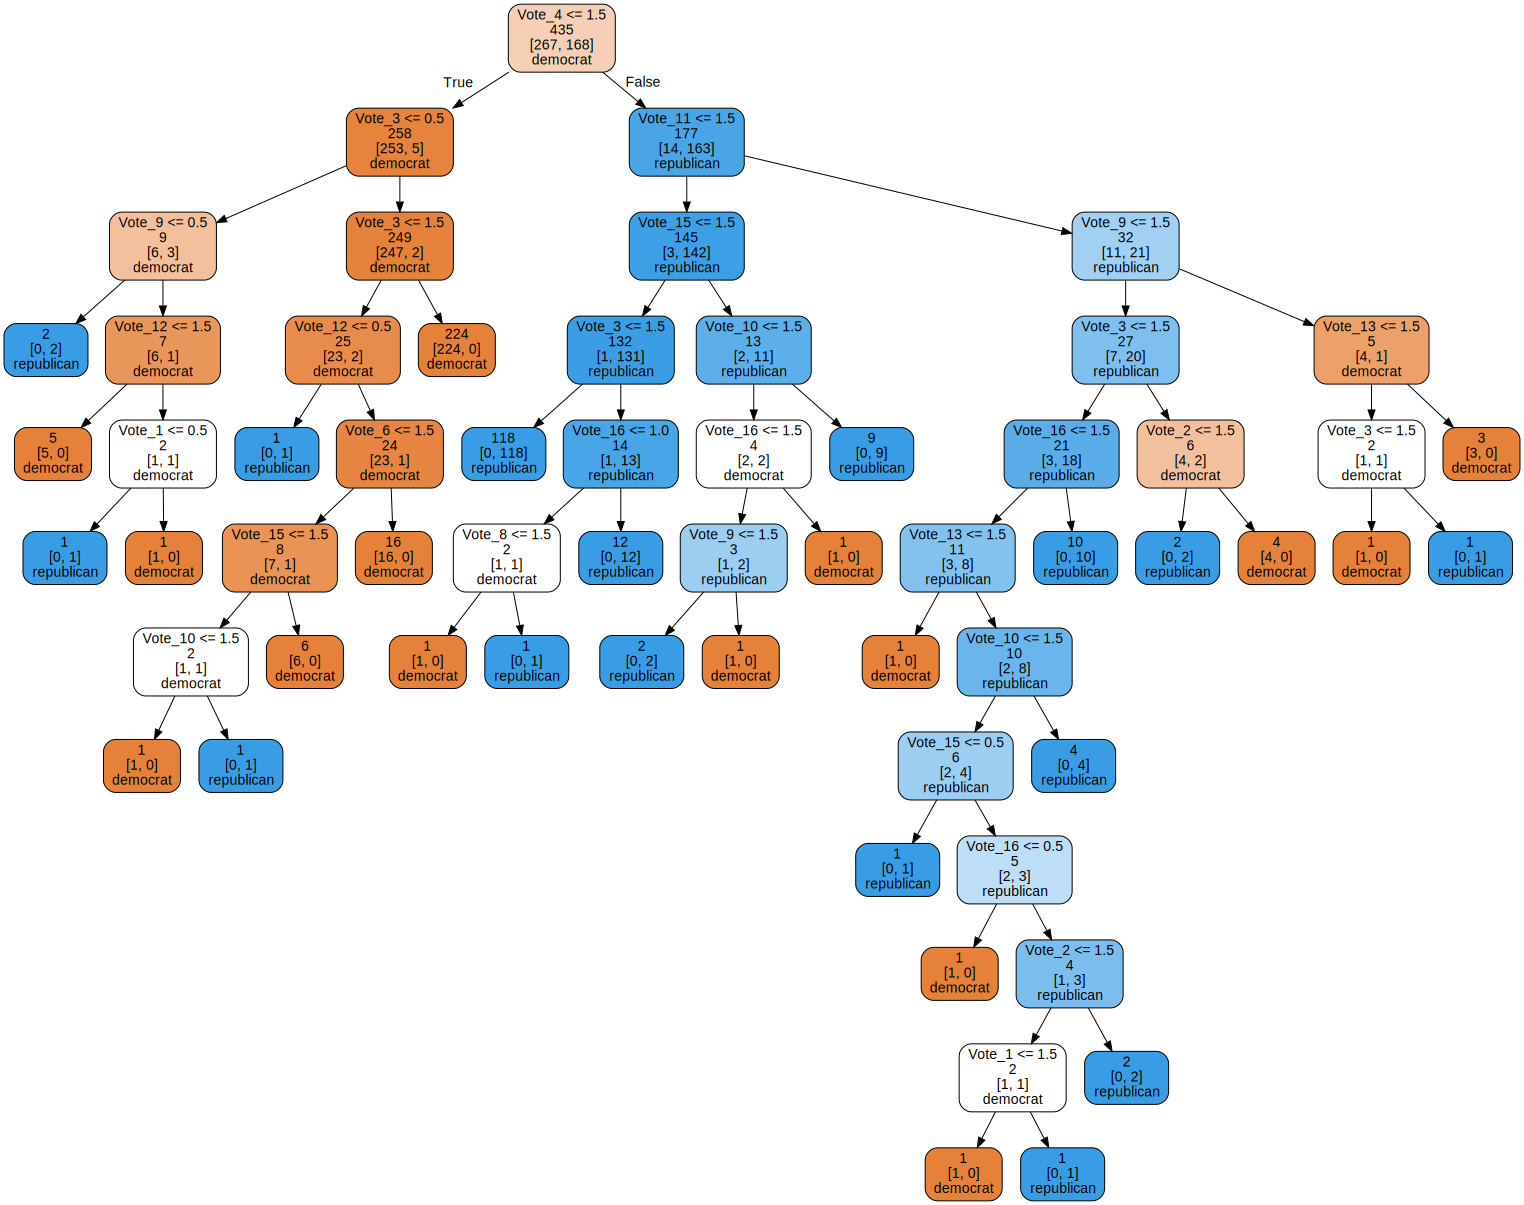

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=list(df_labels.columns.values),
                     class_names=list(sorted(df['class'].unique())),
                     filled=True, rounded=True,
                     special_characters=False,
                     proportion=False, impurity=False, node_ids=False,label=None)
graph = graphviz.Source(dot_data)
graph.render('graph_cartoons') # para gravação em .pdf
graph

e os valores de informações mútua e importância dos atributos.

In [ ]:
print('Mutual information and the attribute with higher Mutual Info: \n')
print(mutual_info_classif(X, y, discrete_features=True))
print(X.columns[ mutual_info_classif(X, y, discrete_features=True).argmax() ])
print()
print('Feature Importances and the attribute with higher Feature Importances: \n')
print(clf.feature_importances_)
print(X.columns[ clf.feature_importances_.argmax() ])

Mutual information and the attribute with higher Mutual Info: 

[8.73872293e-02 2.49962316e-04 2.99660509e-01 5.12951549e-01
 2.92820364e-01 1.02055280e-01 1.37023508e-01 2.35826473e-01
 2.15261646e-01 3.52248115e-03 7.43690939e-02 2.59411124e-01
 1.57899640e-01 2.32400929e-01 1.52771138e-01 7.06865546e-02]
Vote_4

Feature Importances and the attribute with higher Feature Importances: 

[9.69769930e-03 1.53546906e-02 2.81948666e-02 8.27422108e-01
 0.00000000e+00 8.08141609e-04 0.00000000e+00 4.84884965e-03
 2.95109584e-02 1.41486946e-02 2.65326564e-02 1.20136023e-02
 8.55160757e-03 0.00000000e+00 7.38511255e-03 1.55310124e-02]
Vote_4


Vamos então aplicar os classificadores que aprendemos até aqui variando alguns de seus parâmetros.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

base_estimators = [ LogisticRegression(),
                    neighbors.KNeighborsClassifier(),
                    DecisionTreeClassifier(),
                    RandomForestClassifier() ]

param_grids = [ {},
                {'n_neighbors': [3,4,5,6,7]},
                {'max_depth': [2,3,4,5,6,7,8,9,10], 'criterion': ['gini','entropy']},
                {'n_estimators':[3,4,5,6]}]

save_estimators = []

for i in range(len(base_estimators)):
  clf = GridSearchCV(base_estimators[i], param_grids[i], cv=5, scoring='accuracy')
  clf.fit(X_train, y_train)
  # print(clf.cv_results_)
  print(clf.best_estimator_)
  save_estimators.append(clf.best_estimator_)
  print()
  print("Detailed classification report:")
  print()
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  print()




LogisticRegression()

Detailed classification report:

              precision    recall  f1-score   support

    democrat       0.93      0.97      0.95        80
  republican       0.96      0.88      0.92        51

    accuracy                           0.94       131
   macro avg       0.94      0.93      0.93       131
weighted avg       0.94      0.94      0.94       131


KNeighborsClassifier(n_neighbors=4)

Detailed classification report:

              precision    recall  f1-score   support

    democrat       0.94      0.94      0.94        80
  republican       0.90      0.90      0.90        51

    accuracy                           0.92       131
   macro avg       0.92      0.92      0.92       131
weighted avg       0.92      0.92      0.92       131


DecisionTreeClassifier(max_depth=2)

Detailed classification report:

              precision    recall  f1-score   support

    democrat       0.95      0.96      0.96        80
  republican       0.94      0.92      0

Com os parâmetros acima o melhor estimador foi a Árvore de Decisão com o critério `gini` de seleção dos atributos e com uma profundidade máxima de 2 da árvore.

In [ ]:
[x.score(X_test, y_test) for x in save_estimators]

[0.9389312977099237,
 0.9236641221374046,
 0.9465648854961832,
 0.9312977099236641]

In [ ]:
best = np.array( [x.score(X_test, y_test) for x in save_estimators] ).argmax()
save_estimators[best]

DecisionTreeClassifier(max_depth=2)

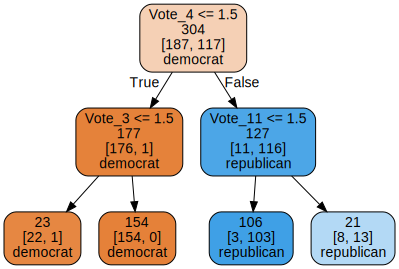

In [ ]:
clf = save_estimators[best]

import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=list(df_labels.columns.values),
                     class_names=list(sorted(df['class'].unique())),
                     filled=True, rounded=True,
                     special_characters=False,
                     proportion=False, impurity=False, node_ids=False,label=None)
graph = graphviz.Source(dot_data)
graph.render('graph_cartoons') # para gravação em .pdf
graph

Você pode acessar a documentação dos dados (http://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names) e verificar a que eleições se referem os votos acima:

* Vote_4: physician-fee-freeze
* Vote_3: adoption-of-the-budget-resolution
* Vote_11: synfuels-corporation-cutback

E, de fato, seria suficiente ainda somente a informação do Vote_4: physician-fee-freeze para classificar os congressistas. Em 1984, o governo federal impõe um congelamento de um ano nos pagamentos para os serviços de saúde, sendo os serviços de saúde  um tema polêmico que ainda hoje divide republicamos e democratas.


# Para Saber Mais

* Acesso https://ml-playground.com/# e experimente alguns modelos de classificação sem qualquer programação. Se estiver interessado ainda pode verificar como exportar e importar dados do https://ml-playground.com/# para o Python. Dica, os dados são salvos e carregados em formato .json.

* O exemplo clássico Árvores de Decisão de Mitchell, Tom Michael (1997) em **Machine Learning** é também explorado em Sayad, Saed (2021). **An Introduction to Data Science**,
Disponível em: https://www.saedsayad.com/data_mining_map.htm e ajuda a entender em um passo a passo como é construída uma árvore de decisão e são calculados o ganho de informação.




# Referências

Weinberger, Kilian. **Machine Learning for Intelligent Systems**, Lecture 28: Decision / Regression Trees
Disponível em:
http://www.cs.cornell.edu/courses/cs4780/2018fa/page18/
Acesso: 14 de Novembro de 2021.

Mitchell, Tom Michael (1997). **Machine Learning**. New York, NY: McGraw-Hill. ISBN 0070428077.

Jake VanderPlas. **Python Data Science Handbook**  O'Reilly Media, Inc. (2016). ISBN: 9781491912058. Disponível em: https://jakevdp.github.io/PythonDataScienceHandbook/. Acesso: 06 de Novembro de 2021.

